<a href="https://colab.research.google.com/github/Meddebma/pyradiomics/blob/master/3D_Classification_Dict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -q "monai-weekly[itk, pillow]"

     |████████████████████████████████| 542kB 3.9MB/s 
     |████████████████████████████████| 50.1MB 110kB/s 
     |████████████████████████████████| 14.4MB 30.6MB/s 
     |████████████████████████████████| 36.3MB 130kB/s 
     |████████████████████████████████| 14.0MB 8.3MB/s 
     |████████████████████████████████| 68.0MB 71kB/s 
     |████████████████████████████████| 10.3MB 48.5MB/s 


In [2]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import logging
import os
import sys
import tempfile
import shutil

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import seaborn as sns 
from glob import glob

import monai
from monai.metrics import compute_roc_auc
from monai.networks.nets import DenseNet121, Classifier
from monai.apps import download_and_extract
from monai.config import print_config
from monai.utils import first
from monai.visualize import GradCAM
from monai.metrics import ConfusionMatrixMetric, get_confusion_matrix
from monai.data import CacheDataset, DataLoader, ImageDataset, ITKReader, PILReader, Dataset, partition_dataset_classes
from sklearn.metrics import (
    classification_report, confusion_matrix,
    ConfusionMatrixDisplay, 
)
from monai.transforms import Activations, Activationsd, AsDiscreted, AddChanneld, Invertd, AsDiscrete, Compose, LoadImaged, RandRotate90d, Resized, ScaleIntensityd, ToTensord

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
print_config()

MONAI version: 0.6.dev2124
Numpy version: 1.19.5
Pytorch version: 1.8.1+cu101
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 35907c20d39845d8bb30bad08cf6cffa87f94389

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.16.2
Pillow version: 7.1.2
Tensorboard version: 2.5.0
gdown version: 3.6.4
TorchVision version: 0.9.1+cu101
ITK version: 5.1.2
tqdm version: 4.41.1
lmdb version: 0.99
psutil version: 5.4.8

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



**Data Direction**

In [3]:
data_dir= "/content/drive/My Drive/Spleen_AI"

In [4]:
labels_all = pd.read_excel (r'/content/drive/MyDrive/Spleen_AI/labels.xlsx')
l=labels_all["label"].to_numpy()
print(l)
#print(labels_all["label"])

[1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 1
 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 1 0 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 0 0 0 1 0 1 1 0 1 1
 1 0 0 1 1 1 1 1 1 1 1 1 1]


In [5]:
images = sorted(glob(os.path.join(data_dir, "Projekt2f", "*.nii.gz")))

#for i in images:
#  print(os.path.basename(i))

labels= l
#labels= np.array([0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1], dtype=np.int64)
print(len(labels))


124


**Loading Data**

In [6]:
train_files = [{"img": img, "label": label} for img, label in zip(images[:100], labels[:100])]
val_files = [{"img": img, "label": label} for img, label in zip(images[-100:], labels[-100:])]

    # Define transforms for image
train_transforms = Compose(
        [
            LoadImaged(keys=["img"]),
            AddChanneld(keys=["img"]),
            ScaleIntensityd(keys=["img"]),
            Resized(keys=["img"], spatial_size=(96, 96, 96)),
            RandRotate90d(keys=["img"], prob=0.8, spatial_axes=[0, 2]),
            ToTensord(keys=["img"]),
        ]
    )
val_transforms = Compose(
        [
            LoadImaged(keys=["img"]),
            AddChanneld(keys=["img"]),
            ScaleIntensityd(keys=["img"]),
            Resized(keys=["img"], spatial_size=(96, 96, 96)),
            ToTensord(keys=["img"]),
        ]
    )
act = Activations(softmax=True)
to_onehot = AsDiscrete(to_onehot=True, n_classes=2)


# Define dataset, data loader
check_ds = monai.data.Dataset(data=train_files, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=2, num_workers=4, pin_memory=torch.cuda.is_available())
check_data = monai.utils.misc.first(check_loader)
print(check_data["img"].shape, check_data["label"])

# create a training data loader
train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4, pin_memory=torch.cuda.is_available())

# create a validation data loader
val_ds = monai.data.Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=2, num_workers=4, pin_memory=torch.cuda.is_available())

post_transforms = Compose([
        #Activationsd(keys="y_pred", sigmoid=True),
        #AsDiscreted(keys="y_pred", threshold_values=True),
        Invertd(
            keys="y_pred",  # invert the `pred` data field, also support multiple fields
            transform=val_transforms,
            loader=val_loader,
            orig_keys="img",  # get the previously applied pre_transforms information on the `img` data field,
                              # then invert `pred` based on this information. we can use same info
                              # for multiple fields, also support different orig_keys for different fields
            #meta_keys="pred_meta_dict",  # key field to save inverted meta data, every item maps to `keys`
            #orig_meta_keys="img_meta_dict",  # get the meta data from `img_meta_dict` field when inverting,
                                             # for example, may need the `affine` to invert `Spacingd` transform,
                                             # multiple fields can use the same meta data to invert
            #meta_key_postfix="meta_dict",  # if `meta_keys=None`, use "{keys}_{meta_key_postfix}" as the meta key,
                                           # if `orig_meta_keys=None`, use "{orig_keys}_{meta_key_postfix}",
                                           # otherwise, no need this arg during inverting
            nearest_interp=True,  # change to use "nearest" mode in interpolation when inverting
            to_tensor=True,  # convert to PyTorch Tensor after inverting
        ),
    ])

torch.Size([2, 1, 96, 96, 96]) tensor([1, 1])


**Training**

In [7]:
# Create DenseNet121, CrossEntropyLoss and Adam optimizer
device = torch.device("cuda")
model = monai.networks.nets.DenseNet121(spatial_dims=3, in_channels=1, out_channels=2).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)

In [8]:
# start a typical PyTorch training
val_interval = 2
best_metric = -1
best_metric_epoch = -1
writer = SummaryWriter()
for epoch in range(5):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{5}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs, labels = batch_data["img"].to(device), batch_data["label"].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_len = len(train_ds) // train_loader.batch_size
            print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
            writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        epoch_loss /= step
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                y_pred = torch.tensor([], dtype=torch.float32, device=device)
                y = torch.tensor([], dtype=torch.long, device=device)
                for val_data in val_loader:
                    val_images, val_labels = val_data["img"].to(device), val_data["label"].to(device)
                    y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                    y = torch.cat([y, val_labels], dim=0)

                acc_value = torch.eq(y_pred.argmax(dim=1), y)
                acc_metric = acc_value.sum().item() / len(acc_value)
                y_onehot = to_onehot(y)
                y_pred_act = act(y_pred)
                auc_metric = compute_roc_auc(y_pred_act, y_onehot)
                del y_pred_act, y_onehot
                if acc_metric > best_metric:
                    best_metric = acc_metric
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), "best_metric_model_classification3d_dict.pth")
                    print("saved new best metric model")
                print(
                    "current epoch: {} current accuracy: {:.4f} current AUC: {:.4f} best accuracy: {:.4f} at epoch {}".format(
                        epoch + 1, acc_metric, auc_metric, best_metric, best_metric_epoch
                    )
                )
                writer.add_scalar("val_accuracy", acc_metric, epoch + 1)
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
writer.close()



----------
epoch 1/5
1/50, train_loss: 0.6393
2/50, train_loss: 0.6776
3/50, train_loss: 0.6279
4/50, train_loss: 0.7164
5/50, train_loss: 0.6433
6/50, train_loss: 0.7373
7/50, train_loss: 0.6969
8/50, train_loss: 0.6914
9/50, train_loss: 0.9545
10/50, train_loss: 0.4852
11/50, train_loss: 0.9488
12/50, train_loss: 0.7156
13/50, train_loss: 0.6865
14/50, train_loss: 0.6919
15/50, train_loss: 0.7127
16/50, train_loss: 0.6993
17/50, train_loss: 0.8415
18/50, train_loss: 0.6985
19/50, train_loss: 0.8215
20/50, train_loss: 0.7010
21/50, train_loss: 0.8323
22/50, train_loss: 0.7132
23/50, train_loss: 0.6036
24/50, train_loss: 0.7356
25/50, train_loss: 0.6866
26/50, train_loss: 0.6987
27/50, train_loss: 0.6274
28/50, train_loss: 0.6684
29/50, train_loss: 0.6713
30/50, train_loss: 0.7131
31/50, train_loss: 0.6996
32/50, train_loss: 0.7128
33/50, train_loss: 0.6027
34/50, train_loss: 0.6835
35/50, train_loss: 0.5464
36/50, train_loss: 0.5643
37/50, train_loss: 0.6934
38/50, train_loss: 0.7235


**Evaluation Metrics**

                 precision    recall  f1-score   support

Liver_Cirrhosis       0.73      0.70      0.71        43
       Lymphoma       0.78      0.81      0.79        57

       accuracy                           0.76       100
      macro avg       0.76      0.75      0.75       100
   weighted avg       0.76      0.76      0.76       100



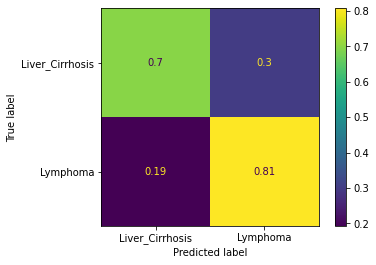

In [11]:
from enum import Enum
from sklearn.metrics import (
    classification_report, confusion_matrix,
    ConfusionMatrixDisplay
)
class Diagnosis(Enum):
    Liver_Cirrhosis = 0
    Lymphoma = 1
    

%matplotlib inline
# Load best model
model.load_state_dict(torch.load("/content/drive/My Drive/Spleen_AI/best_metric_model_classification3d_array.pth"))
model.to(device)
model.eval()

with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)

    for val_data in val_loader:
              val_images, val_labels = val_data["img"].to(device), val_data["label"].to(device),
              outputs = model(val_images)
              y = torch.cat([y, val_labels], dim=0)
              y_pred = torch.cat([y_pred, outputs.argmax(dim=1)], dim=0)
        
print(classification_report(
    y.cpu().numpy(),
    y_pred.cpu().numpy(),
    target_names=[d.name for d in Diagnosis]))

cm = confusion_matrix (
    y.cpu().numpy(),
    y_pred.cpu().numpy(),
    normalize='true',
)
cmm = ConfusionMatrixMetric (include_background=True, metric_name=["sensitivity","specificity","negative predictive value"])

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[d.name for d in Diagnosis],
)
disp.plot(ax=plt.subplots(1, 1, facecolor='white')[1])

In [25]:
post_transforms = Compose([
        #Activationsd(keys="y_pred", sigmoid=True),
        #AsDiscreted(keys="y_pred", threshold_values=True),
        Invertd(
            keys="y_pred",  # invert the `pred` data field, also support multiple fields
            transform=val_transforms,
            loader=val_loader,
            orig_keys="img",  # get the previously applied pre_transforms information on the `img` data field,
                              # then invert `pred` based on this information. we can use same info
                              # for multiple fields, also support different orig_keys for different fields
            #meta_keys="pred_meta_dict",  # key field to save inverted meta data, every item maps to `keys`
            #orig_meta_keys="img_meta_dict",  # get the meta data from `img_meta_dict` field when inverting,
                                             # for example, may need the `affine` to invert `Spacingd` transform,
                                             # multiple fields can use the same meta data to invert
            #meta_key_postfix="meta_dict",  # if `meta_keys=None`, use "{keys}_{meta_key_postfix}" as the meta key,
                                           # if `orig_meta_keys=None`, use "{orig_keys}_{meta_key_postfix}",
                                           # otherwise, no need this arg during inverting
            nearest_interp=True,  # change to use "nearest" mode in interpolation when inverting
            to_tensor=True,  # convert to PyTorch Tensor after inverting
        ),
    ])

val_ds = monai.data.Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=2, num_workers=4, pin_memory=torch.cuda.is_available())

with torch.no_grad():
  for d in val_loader:
         post_transforms(d)
         itera = iter(d)



def get_next_im():
    test_data = next(itera)
    return test_data[0].to(device), test_data[1].unsqueeze(0).to(device)


def plot_occlusion_heatmap(im, heatmap):
    plt.subplots(1, 2)
    plt.subplot(1, 2, 1)
    plt.imshow(np.squeeze(im.cpu()))
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.imshow(heatmap)
    plt.colorbar()
    plt.show()


=== Transform input info -- Invertd ===

=== Transform input info -- Invertd ===
INFO:DataStats:
=== Transform input info -- Invertd ===
img statistics:
Type: <class 'torch.Tensor'>
Shape: torch.Size([2, 1, 96, 96, 96])
Value range: (0.0, 0.8472548127174377)
img statistics:
Type: <class 'torch.Tensor'>
Shape: torch.Size([2, 1, 96, 96, 96])
Value range: (0.0, 0.8472548127174377)
INFO:DataStats:img statistics:
Type: <class 'torch.Tensor'>
Shape: torch.Size([2, 1, 96, 96, 96])
Value range: (0.0, 0.8472548127174377)
label statistics:
Type: <class 'torch.Tensor'>
Shape: torch.Size([2])
Value range: (0, 1)
label statistics:
Type: <class 'torch.Tensor'>
Shape: torch.Size([2])
Value range: (0, 1)
INFO:DataStats:label statistics:
Type: <class 'torch.Tensor'>
Shape: torch.Size([2])
Value range: (0, 1)
img_meta_dict statistics:
Type: <class 'dict'>
Value: {'sizeof_hdr': tensor([348, 348], dtype=torch.int32), 'extents': tensor([0, 0], dtype=torch.int32), 'session_error': tensor([0, 0], dtype=torc

RuntimeError: ignored

In [23]:
# Get a random image and its corresponding label
img, label = get_next_im()

# Get the occlusion sensitivity map
occ_sens = monai.visualize.OcclusionSensitivity(
    nn_module=model, mask_size=12, n_batch=10, stride=12)
# Get the CAM
cam = monai.visualize.GradCAM(
    nn_module=model, target_layers="class_layers.relu"
)
# Only get a single slice to save time.
# For the other dimensions (channel, width, height), use
# -1 to use 0 and img.shape[x]-1 for min and max, respectively
depth_slice = img[0][0]

occ_sens_b_box = [-1, -1, depth_slice, depth_slice, -1, -1, -1, -1]

occ_result, _ = occ_sens(x=img, b_box=occ_sens_b_box)
occ_result = occ_result[..., label.item()]
cam_result = cam(x=img, class_idx=None)
cam_result = cam_result[..., depth_slice]


fig, axes = plt.subplots(1, 3, figsize=(25, 15), facecolor='white')

for i, im in enumerate([img[:, :, depth_slice, ...], occ_result, cam_result]):
    cmap = 'gray' if i == 0 else 'jet'
    ax = axes[i]
    if isinstance(im, torch.Tensor):
        im = im.cpu().detach()    
    #im_show = ax.imshow(im[0][0], cmap=cmap)
    im_show = ax.imshow(np.squeeze(im[0][0]), cmap=cmap)
    ax.axis('off')
    fig.colorbar(im_show, ax=ax)



KeyError: ignored